In [1]:
import torch
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import PIL.Image
import numpy as np
from torchvision.utils import make_grid
import PIL.Image

In [2]:
from data import RawWaterMeterDS
from utils import coordinate_rotation_transform, show

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.Size([3, 960, 540])

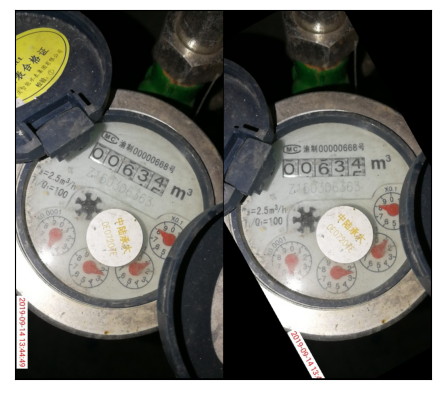

In [3]:
DS = RawWaterMeterDS()
# default RawDataset return (img, rotated angles)
img, ang = DS[2]
show(make_grid([img, transforms.RandomRotation([ang * 90, ang * 90])(img)]))
DS[2][0].shape

In [7]:
from models.RotationRegressionNetwork import rota_reg_net_resnet18
net = rota_reg_net_resnet18()

In [114]:
from utils import tuple_collate_fn
dl = data.DataLoader(DS, 16, True, collate_fn=tuple_collate_fn)

In [127]:
optim = torch.optim.Adam(net.parameters(), lr=0.0002)

In [128]:
net.to(device)
net.train()
for epoch in range(10):
    mean_loss = 0
    for i, (X, y) in enumerate(dl):
        optim.zero_grad()
        loss_dict, _ = net(X, y)
        loss = loss_dict['mae_loss']
        mean_loss += loss.item()
        if (i + 1) % 20 == 0:
            print(mean_loss / 20)
            mean_loss = 0
        loss.backward()
        optim.step()

0.008448562677949667
0.008394927624613047
0.008970861509442329
0.0076827616430819035
0.008318936405703425
0.007896979409269988
0.007339765015058219
0.007755112496670336
0.007329537556506694
0.007488182815723121
0.006380979437381029
0.006985874508973211
0.007397947693243622
0.007117248349823057
0.005704510328359902
0.005705491814296693
0.006854894175194204
0.007776060071773827
0.006404063198715448
0.0057166358106769625
0.006452132540289313
0.006392857024911791
0.0062386380159296095
0.006275115220341831
0.006356140645220876


KeyboardInterrupt: 

In [129]:
# test model precision
with torch.no_grad():
    net.eval()
    num_less_5, num_less_10 = 0, 0
    for X, y in dl:
        res = torch.abs(net(X, y) - torch.cat(y, dim=0).to(device) * 90)
        num_less_10 += (res < 10.0).sum()
        num_less_5 += (res < 5.0).sum()
    print(num_less_10 / 1000, num_less_5 / 1000)

tensor(0.7790, device='cuda:0') tensor(0.4540, device='cuda:0')


In [157]:
TDS = RawWaterMeterDS('test')
for _ in range(500):
    img = transforms.ToTensor()(PIL.Image.open(f'WaterMeterDataset/test_imgs/test_imgs/test_{_ + 1}.jpg'))
    rot = net(img)
    img = transforms.RandomRotation([rot, rot])(img)
    img = transforms.ToPILImage()(img)
    img.save(f'WaterMeterDataset/ProcessedData/test_imgs/test_imgs/test_{_ + 1}.jpg')

In [177]:
def trans(target):
    ts = target.split()
    coordinate_list = [int(str_digit) for str_digit in ts[0: 8]]
    x_0, y_0, x_1, y_1 = coordinate_list[0: 4]
    if (x_1 - x_0) == 0:
        return torch.tensor([[1.0]])
    k = (y_1 - y_0) / (x_1 - x_0)
    angel = torch.atan(torch.tensor([[k]])) / torch.pi * 180.0 / 90.0

    return angel, coordinate_list, ts[8: ]

In [83]:
TTDS = RawWaterMeterDS('train', root='WaterMeterDataset', target_transform=trans)

In [181]:
for idx in range(1000):
    img = TTDS[idx][0]
    rot = TTDS[idx][1][0] * 90
    central_posi = (TTDS[idx][0].shape[1] // 2, TTDS[idx][0].shape[2] // 2)
    coors = coordinate_rotation_transform(TTDS[idx][1][1], central_posi, rot, swap_xy=False).to(torch.int)
    digits = ''
    for i in TTDS[idx][1][2]:
        digits += i + ' '
    f = open(f'WaterMeterDataset/ProcessedData/train_labels/labels/train_{idx + 1}.txt', mode='w')
    f.write(str(coors.numpy())[1: -1] + ' ' + digits)
    f.close()
    img = transforms.ToPILImage()(img)
    img.save(f'WaterMeterDataset/ProcessedData/train_imgs/train_{idx + 1}.jpg')